In [1]:
import pandas as pd

df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(), df.shape


(   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
 0  7590-VHVEG  Female              0     Yes         No       1           No   
 1  5575-GNVDE    Male              0      No         No      34          Yes   
 2  3668-QPYBK    Male              0      No         No       2          Yes   
 3  7795-CFOCW    Male              0      No         No      45           No   
 4  9237-HQITU  Female              0      No         No       2          Yes   
 
       MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
 0  No phone service             DSL             No  ...               No   
 1                No             DSL            Yes  ...              Yes   
 2                No             DSL            Yes  ...               No   
 3  No phone service             DSL            Yes  ...              Yes   
 4                No     Fiber optic             No  ...               No   
 
   TechSupport StreamingTV StreamingMovies      

In [2]:
df["Churn"].value_counts()


,count
Churn,
No,5174
Yes,1869


In [3]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


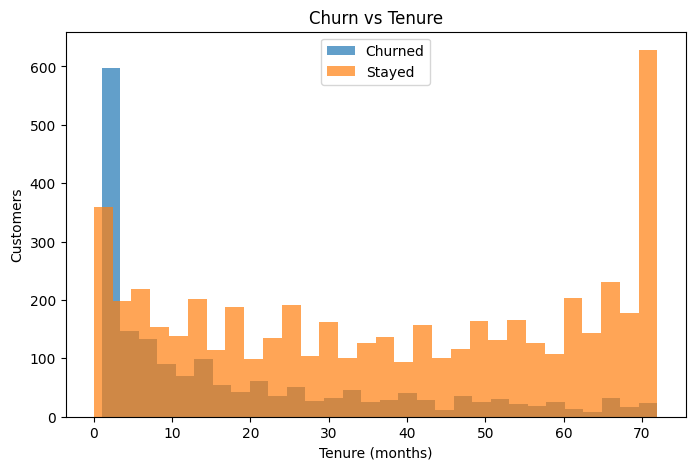

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.hist(df[df["Churn"]==1]["tenure"], bins=30, alpha=0.7, label="Churned")
plt.hist(df[df["Churn"]==0]["tenure"], bins=30, alpha=0.7, label="Stayed")
plt.legend()
plt.xlabel("Tenure (months)")
plt.ylabel("Customers")
plt.title("Churn vs Tenure")
plt.show()

/tmp/ipython-input-4051789240.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([


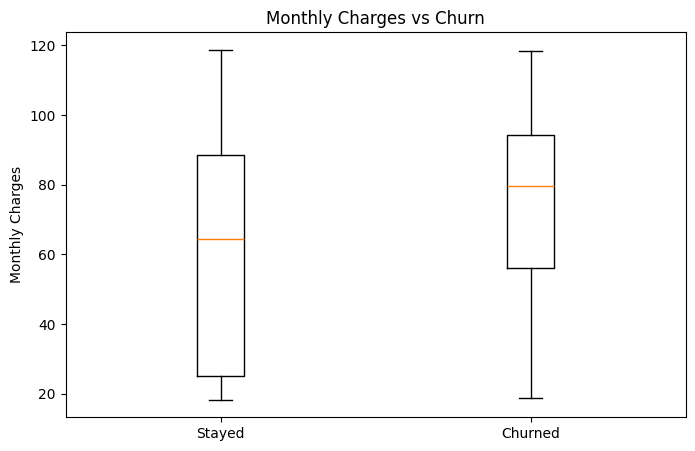

In [5]:
plt.figure(figsize=(8,5))
plt.boxplot([
    df[df["Churn"]==0]["MonthlyCharges"],
    df[df["Churn"]==1]["MonthlyCharges"]
], labels=["Stayed", "Churned"])
plt.ylabel("Monthly Charges")
plt.title("Monthly Charges vs Churn")
plt.show()


In [6]:
pd.crosstab(df["Contract"], df["Churn"], normalize="index")

Churn,0,1
Contract,,
Month-to-month,0.572903,0.427097
One year,0.887305,0.112695
Two year,0.971681,0.028319


In [7]:
pd.crosstab(df["InternetService"], df["Churn"], normalize="index")

Churn,0,1
InternetService,,
DSL,0.810409,0.189591
Fiber optic,0.581072,0.418928
No,0.925950,0.074050


In [8]:
pd.crosstab(df["PaymentMethod"], df["Churn"], normalize="index")

Churn,0,1
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


In [9]:
df = df.drop("customerID", axis=1)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

df = df.dropna()

In [10]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X = pd.get_dummies(X, drop_first=True)


In [11]:
X.shape

(7032, 30)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [14]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407

ROC AUC: 0.8321357760740484


In [15]:
import pandas as pd

feature_importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
})

# Sort by absolute impact
feature_importance["Impact"] = feature_importance["Coefficient"].abs()
feature_importance = feature_importance.sort_values("Impact", ascending=False)

feature_importance.head(10)

,Feature,Coefficient,Impact
25,Contract_Two year,-1.308117,1.308117
24,Contract_One year,-0.760510,0.760510
10,InternetService_Fiber optic,0.667972,0.667972
13,OnlineSecurity_Yes,-0.467520,0.467520
19,TechSupport_Yes,-0.444962,0.444962
7,PhoneService_Yes,-0.442127,0.442127
26,PaperlessBilling_Yes,0.275182,0.275182
28,PaymentMethod_Electronic check,0.265597,0.265597
8,MultipleLines_No phone service,0.264738,0.264738
0,SeniorCitizen,0.258251,0.258251


In [16]:
df["Churn_Probability"] = model.predict_proba(X)[:,1]
df[["tenure","MonthlyCharges","Contract","InternetService","PaymentMethod","Churn_Probability"]].head()

,tenure,MonthlyCharges,Contract,InternetService,PaymentMethod,Churn_Probability
0,1,29.85,Month-to-month,DSL,Electronic check,0.644249
1,34,56.95,One year,DSL,Mailed check,0.038834
2,2,53.85,Month-to-month,DSL,Mailed check,0.284631
3,45,42.30,One year,DSL,Bank transfer (automatic),0.025700
4,2,70.70,Month-to-month,Fiber optic,Electronic check,0.689124


In [17]:
high_risk = df[df["Churn_Probability"] > 0.7]

high_risk.shape

(469, 21)

In [18]:
high_risk[["tenure","MonthlyCharges","Contract","InternetService","PaymentMethod","Churn_Probability"]].head(10)


,tenure,MonthlyCharges,Contract,InternetService,PaymentMethod,Churn_Probability
5,8,99.65,Month-to-month,Fiber optic,Electronic check,0.787031
20,1,39.65,Month-to-month,DSL,Electronic check,0.752574
31,2,95.50,Month-to-month,Fiber optic,Credit card (automatic),0.754709
39,11,97.85,Month-to-month,Fiber optic,Bank transfer (automatic),0.720027
47,2,80.65,Month-to-month,Fiber optic,Electronic check,0.734370
55,18,95.45,Month-to-month,Fiber optic,Electronic check,0.778067
64,9,94.40,Month-to-month,Fiber optic,Electronic check,0.731719
122,3,74.40,Month-to-month,Fiber optic,Electronic check,0.719290
130,13,85.95,Month-to-month,Fiber optic,Electronic check,0.718163
133,1,35.45,Month-to-month,DSL,Electronic check,0.706283


In [19]:
lost_revenue = high_risk["MonthlyCharges"].sum()
lost_revenue

np.float64(39893.15)

In [20]:
high_risk["Contract"].value_counts()

,count
Contract,
Month-to-month,469


In [21]:
high_risk["InternetService"].value_counts()

,count
InternetService,
Fiber optic,445
DSL,24


In [22]:
import pickle

with open("churn_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')